**Regularisation**

In this example you are given a dataset (MNIST) with a limited number of training examples (only 1000 compared to the usual 60,000). 

Your goal is to implement regularisation methods to achive the **lowest possible test loss using this dataset**. 

You should consider methods given in the lectures including:

*   Data augmentation
*   Early stopping
*   L1/L2 penalty norms
*   Dropout

You are free to change the network architecture and model complexity, but the main purpose of the workshop is to investigate regularisation (next week you will look at CNN architectures in detail). 

You are also free to change the choice of optimiser, and other hyper-parameters such as the batch size.  


In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.python.keras import regularizers

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import numpy as np

In [5]:
tf.random.set_seed(1)

In [6]:
print(tf.__version__)

2.4.1


First load the MNIST dataset and add a channels dimension (channels last convention)

In [7]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]

11493376/11490434 [==============================] - 0s 0us/step


Let's use a much smaller training dataset of 1000 examples so overfitting is more problematic

In [8]:
n_train = 1000
x_train = x_train[0:n_train, :]
y_train = y_train[0:n_train]

print(x_train.shape)
print(x_test.shape)

(1000, 28, 28, 1)
(10000, 28, 28, 1)


In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Let's visualise several training examples - to do this we use the keras ImageDataGenerator. We rescale images by 1/255 to normalise them in the range (0, 1)

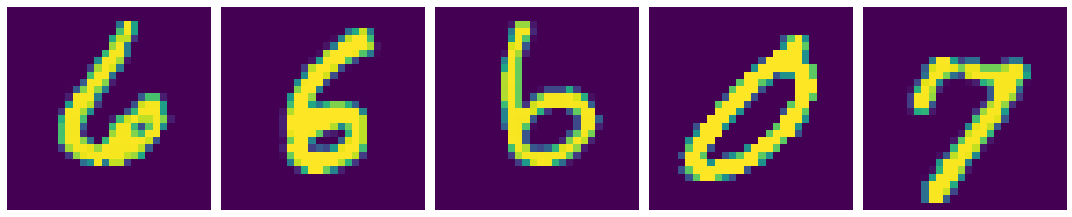

In [10]:
image_generator = ImageDataGenerator(rescale=1./255) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
sample_images, sample_labels = next(data_gen)
plotImages(sample_images[:5])

One regularisation method to deal with over-fitting is data augmentation. The image generator can apply various transformations to data - here we apply a random rotation of upto 20 degrees and visualise the same training example with different augmentations

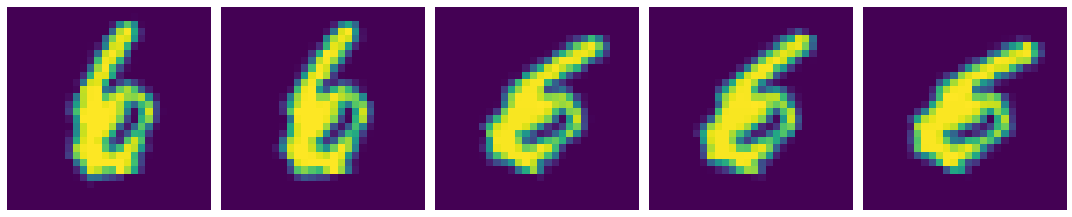

In [11]:
image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
augmented_images = [data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Define a basic CNN with 32 convolutional filters using a 3x3 kernel, followed by a dense fully connected layer of 128 units and an output layer of 10 units with softmax activation 

In [13]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01))
    self.conv2 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))
    self.drop1 = Dropout(0.25)
    self.flatten = Flatten()
    self.batch1 = BatchNormalization()
    self.d1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))
    self.drop2 = Dropout(0.25)
    self.batch2 = BatchNormalization()
    self.d2 = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.drop1(x)
    x = self.flatten(x)
    x = self.batch1(x)
    x = self.d1(x)
    x = self.drop2(x)
    x = self.batch2(x)
    return self.d2(x)

Main training routine - uses the more detailed Gradient Tape API to iterate over the dataset and update the weights

In [14]:
def trainer(cls, train_image_generator, test_image_generator, 
            verbose=False, batch_size=32, max_epochs=5):
  
  model = cls()

  train_data_gen = train_image_generator.flow(x_train, y_train, 
                                              batch_size=batch_size) 

  test_data_gen = test_image_generator.flow(x_test, y_test, 
                                              batch_size=batch_size) 

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
  optimizer = tf.keras.optimizers.Adam()

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')

  @tf.function
  def train_step(images, labels):
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

  @tf.function
  def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

  for epoch in range(max_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    batches = 0
    for images, labels in train_data_gen:
      #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
      train_step(images, labels)
      batches += 1
      if batches >= len(x_train) / batch_size:
        break

    batches = 0
    for images, labels in test_data_gen:
      test_step(images, labels)
      batches += 1
      if batches >= len(x_test) / batch_size:
        break

    if verbose:
      template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
      print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
    
  return test_loss.result().numpy()

Baseline run with no regularisation

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.9168705940246582, Accuracy: 71.69999694824219, Test Loss: 0.5159050226211548, Test Accuracy: 84.04000091552734
Epoch 2, Loss: 0.3103785216808319, Accuracy: 90.10000610351562, Test Loss: 0.5231049060821533, Test Accuracy: 84.11000061035156
Epoch 3, Loss: 0.15446731448173523, Accuracy: 95.70000457763672, Test Loss: 0.473871111869812, Test Accuracy: 86.12999725341797
Epoch 4, Loss: 0.09344244003295898, Accuracy: 97.0999984741211, Test Loss: 0.41211143136024475, Test Accuracy: 87.52999877929688
Epoch 5, Loss: 0.042409107089042664, Accuracy: 99.5999984741211, Test Loss: 0.3940218389034271, Test Accuracy: 89.20999908447266
Epoch 6, Loss: 0.016148187220096588, Accuracy: 99.9000015258789, Test Loss: 0.3967156708240509, Test Accuracy: 89.61000061035156
Epoch 7, Loss: 0.008472408168017864, Accuracy: 100.0, Test Loss: 0.4250642955303192, Test Accuracy: 89.3499984741211
Epoch 8, Loss: 0.004662804771214724, Accuracy: 100.0, Test Loss: 0.4301902651786804, Test Accuracy: 89.440002441

Adding image Augmentation

In [ ]:

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.1747320890426636, Accuracy: 61.099998474121094, Test Loss: 0.5275986790657043, Test Accuracy: 83.09000396728516
Epoch 2, Loss: 0.49886056780815125, Accuracy: 84.0, Test Loss: 0.44402480125427246, Test Accuracy: 85.62999725341797
Epoch 3, Loss: 0.3586411476135254, Accuracy: 88.70000457763672, Test Loss: 0.3817662298679352, Test Accuracy: 87.44000244140625
Epoch 4, Loss: 0.29676470160484314, Accuracy: 92.0999984741211, Test Loss: 0.319560170173645, Test Accuracy: 89.9800033569336
Epoch 5, Loss: 0.20366619527339935, Accuracy: 93.5, Test Loss: 0.3157195746898651, Test Accuracy: 90.01000213623047
Epoch 6, Loss: 0.15860511362552643, Accuracy: 95.9000015258789, Test Loss: 0.2844456434249878, Test Accuracy: 90.88999938964844
Epoch 7, Loss: 0.13208745419979095, Accuracy: 95.9000015258789, Test Loss: 0.27122944593429565, Test Accuracy: 91.75
Epoch 8, Loss: 0.1069456934928894, Accuracy: 96.80000305175781, Test Loss: 0.27757471799850464, Test Accuracy: 91.81999969482422
Epoch 9, L

Changing Architecture - Added 2 dropout layers


In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.265486717224121, Accuracy: 57.599998474121094, Test Loss: 0.5880975127220154, Test Accuracy: 82.41999816894531
Epoch 2, Loss: 0.5945870280265808, Accuracy: 83.5, Test Loss: 0.47371548414230347, Test Accuracy: 85.38999938964844
Epoch 3, Loss: 0.39454126358032227, Accuracy: 87.69999694824219, Test Loss: 0.4066397547721863, Test Accuracy: 87.45999908447266
Epoch 4, Loss: 0.30924004316329956, Accuracy: 90.80000305175781, Test Loss: 0.3578096926212311, Test Accuracy: 89.06000518798828
Epoch 5, Loss: 0.24542272090911865, Accuracy: 92.69999694824219, Test Loss: 0.36670488119125366, Test Accuracy: 89.16000366210938
Epoch 6, Loss: 0.18803288042545319, Accuracy: 94.5999984741211, Test Loss: 0.32927027344703674, Test Accuracy: 90.27000427246094
Epoch 7, Loss: 0.14795465767383575, Accuracy: 95.70000457763672, Test Loss: 0.3216382563114166, Test Accuracy: 90.09000396728516
Epoch 8, Loss: 0.09477434307336807, Accuracy: 97.0999984741211, Test Loss: 0.32558366656303406, Test Accuracy:

Dropout plus image Augmentation

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.335269808769226, Accuracy: 55.5, Test Loss: 0.5781012773513794, Test Accuracy: 82.95999908447266
Epoch 2, Loss: 0.7580810785293579, Accuracy: 74.9000015258789, Test Loss: 0.48384585976600647, Test Accuracy: 84.88999938964844
Epoch 3, Loss: 0.5601168870925903, Accuracy: 82.0999984741211, Test Loss: 0.35914257168769836, Test Accuracy: 88.66999816894531
Epoch 4, Loss: 0.5481895208358765, Accuracy: 82.5, Test Loss: 0.3210331201553345, Test Accuracy: 89.86000061035156
Epoch 5, Loss: 0.46746018528938293, Accuracy: 86.5, Test Loss: 0.3065767288208008, Test Accuracy: 90.16000366210938
Epoch 6, Loss: 0.42873650789260864, Accuracy: 87.0999984741211, Test Loss: 0.2648230493068695, Test Accuracy: 91.7699966430664
Epoch 7, Loss: 0.33003726601600647, Accuracy: 89.0999984741211, Test Loss: 0.2454458624124527, Test Accuracy: 92.29000091552734
Epoch 8, Loss: 0.3008411228656769, Accuracy: 90.80000305175781, Test Loss: 0.24480657279491425, Test Accuracy: 92.3699951171875
Epoch 9, Loss: 0

Added another convulational layer

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.3962639570236206, Accuracy: 51.70000076293945, Test Loss: 0.5687040090560913, Test Accuracy: 82.27000427246094
Epoch 2, Loss: 0.7010168433189392, Accuracy: 78.19999694824219, Test Loss: 0.3811497390270233, Test Accuracy: 87.22000122070312
Epoch 3, Loss: 0.4507678151130676, Accuracy: 84.79999542236328, Test Loss: 0.26753565669059753, Test Accuracy: 91.80999755859375
Epoch 4, Loss: 0.4280616044998169, Accuracy: 88.0999984741211, Test Loss: 0.2445094883441925, Test Accuracy: 92.07999420166016
Epoch 5, Loss: 0.34914642572402954, Accuracy: 89.70000457763672, Test Loss: 0.22245772182941437, Test Accuracy: 93.11000061035156
Epoch 6, Loss: 0.26905301213264465, Accuracy: 91.29999542236328, Test Loss: 0.2122645527124405, Test Accuracy: 93.33999633789062
Epoch 7, Loss: 0.24030852317810059, Accuracy: 91.79999542236328, Test Loss: 0.19726204872131348, Test Accuracy: 93.83999633789062
Epoch 8, Loss: 0.2154054343700409, Accuracy: 93.9000015258789, Test Loss: 0.181350976228714, Test A

Adding L2 Regularisation

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=25) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.3833023309707642, Accuracy: 52.79999923706055, Test Loss: 0.5343092083930969, Test Accuracy: 83.5
Epoch 2, Loss: 0.6565513014793396, Accuracy: 79.0999984741211, Test Loss: 0.3259616792201996, Test Accuracy: 90.26000213623047
Epoch 3, Loss: 0.4710690975189209, Accuracy: 84.4000015258789, Test Loss: 0.2600972652435303, Test Accuracy: 91.91999816894531
Epoch 4, Loss: 0.37585803866386414, Accuracy: 87.80000305175781, Test Loss: 0.20492039620876312, Test Accuracy: 93.33000183105469
Epoch 5, Loss: 0.29680514335632324, Accuracy: 89.5, Test Loss: 0.19802945852279663, Test Accuracy: 93.70999908447266
Epoch 6, Loss: 0.21732796728610992, Accuracy: 93.4000015258789, Test Loss: 0.20133771002292633, Test Accuracy: 93.58999633789062
Epoch 7, Loss: 0.26244843006134033, Accuracy: 91.69999694824219, Test Loss: 0.17383913695812225, Test Accuracy: 94.4800033569336
Epoch 8, Loss: 0.18731361627578735, Accuracy: 95.0999984741211, Test Loss: 0.16059915721416473, Test Accuracy: 95.139999389648

Adding 2 batch normalisation layers



In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.1036397218704224, Accuracy: 66.39999389648438, Test Loss: 1.800807237625122, Test Accuracy: 58.79999923706055
Epoch 2, Loss: 0.47866109013557434, Accuracy: 86.0999984741211, Test Loss: 1.99521005153656, Test Accuracy: 29.850000381469727
Epoch 3, Loss: 0.2817516326904297, Accuracy: 92.69999694824219, Test Loss: 2.112365245819092, Test Accuracy: 13.49000072479248
Epoch 4, Loss: 0.22245772182941437, Accuracy: 93.80000305175781, Test Loss: 2.041639566421509, Test Accuracy: 28.969999313354492
Epoch 5, Loss: 0.17316193878650665, Accuracy: 95.5, Test Loss: 1.9788901805877686, Test Accuracy: 32.900001525878906
Epoch 6, Loss: 0.1357235163450241, Accuracy: 96.10000610351562, Test Loss: 2.029604434967041, Test Accuracy: 32.36000061035156
Epoch 7, Loss: 0.10603106766939163, Accuracy: 97.29999542236328, Test Loss: 1.8716946840286255, Test Accuracy: 34.95000076293945
Epoch 8, Loss: 0.08840974420309067, Accuracy: 97.5, Test Loss: 1.7613372802734375, Test Accuracy: 40.20000076293945
E